In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks, optimizers

from sklearn.datasets import fetch_20newsgroups
from transformers import TFDistilBertModel, DistilBertTokenizer, DistilBertConfig

2022-12-18 06:00:44.791367: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-18 06:00:44.792442: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-18 06:00:44.793154: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-18 06:00:44.794953: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

## Data Preperation

In [2]:
x_train, y_train = fetch_20newsgroups(subset='train', return_X_y=True)
x_valid, y_valid = fetch_20newsgroups(subset='test', return_X_y=True)

n_classes = 20
checkpoint = 'distilbert-base-uncased'
input_shape = 512

In [3]:
%%time

tokenizer = DistilBertTokenizer.from_pretrained(checkpoint)
x_train = tokenizer(x_train, truncation=True, padding='max_length')
x_valid = tokenizer(x_valid, truncation=True, padding='max_length')

x_train = [np.array(x_train['input_ids']), np.array(x_train['attention_mask'])]
x_valid = [np.array(x_valid['input_ids']), np.array(x_valid['attention_mask'])]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

CPU times: user 2min 55s, sys: 358 ms, total: 2min 55s
Wall time: 3min


## Callbacks

In [4]:
import os
class LearningCurve(callbacks.Callback):
    def __init__(self, metrics_to_plot, directory):
        self.metrics_to_plot = metrics_to_plot
        self.directory = directory
        if not os.path.exists(directory):
            os.mkdir(directory)


    def on_train_begin(self, logs):
        self.metric_logs = []
  
    def on_epoch_end(self, epoch, logs):
        self.metric_logs.append(logs)

    def on_train_end(self, logs):
        metrics_df = pd.DataFrame(self.metric_logs)
        for metric in self.metrics_to_plot:
            fig, ax = plt.subplots(figsize=(20, 6))
            fig.suptitle(metric.title(), fontsize=18)
            metrics_df[[metric, f'val_{metric}']].plot(style='o-', ax=ax)
            plt.savefig(os.path.join(self.directory, metric))
            plt.show()

        self.metric_logs = []
        
get_callbacks = lambda x: [
    LearningCurve(['loss', 'accuracy'], x), 
    callbacks.EarlyStopping(patience=3, restore_best_weights=True, verbose=1)
]

## Model

Downloading:   0%|          | 0.00/347M [00:00<?, ?B/s]

2022-12-18 06:04:14.458612: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'vocab_transform', 'activation_13', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the 

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_token (InputLayer)        [(None, 512)]        0                                            
__________________________________________________________________________________________________
masked_token (InputLayer)       [(None, 512)]        0                                            
__________________________________________________________________________________________________
tf_distil_bert_model (TFDistilB TFBaseModelOutput(la 66362880    input_token[0][0]                
                                                                 masked_token[0][0]               
__________________________________________________________________________________________________
global_average_pooling1d (Globa (None, 768)          0           tf_distil_bert_model[0][0]   

2022-12-18 06:04:20.700568: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
1415/1415 [==============================] - 498s 347ms/step - loss: 0.8292 - accuracy: 0.7500 - val_loss: 0.7363 - val_accuracy: 0.7945
Epoch 2/10
1415/1415 [==============================] - 489s 346ms/step - loss: 0.3226 - accuracy: 0.9055 - val_loss: 0.7466 - val_accuracy: 0.8019
Epoch 3/10
1415/1415 [==============================] - 489s 345ms/step - loss: 0.1783 - accuracy: 0.9495 - val_loss: 0.7524 - val_accuracy: 0.8201
Epoch 4/10
1415/1415 [==============================] - 489s 345ms/step - loss: 0.1381 - accuracy: 0.9618 - val_loss: 0.8164 - val_accuracy: 0.8152
Restoring model weights from the end of the best epoch.


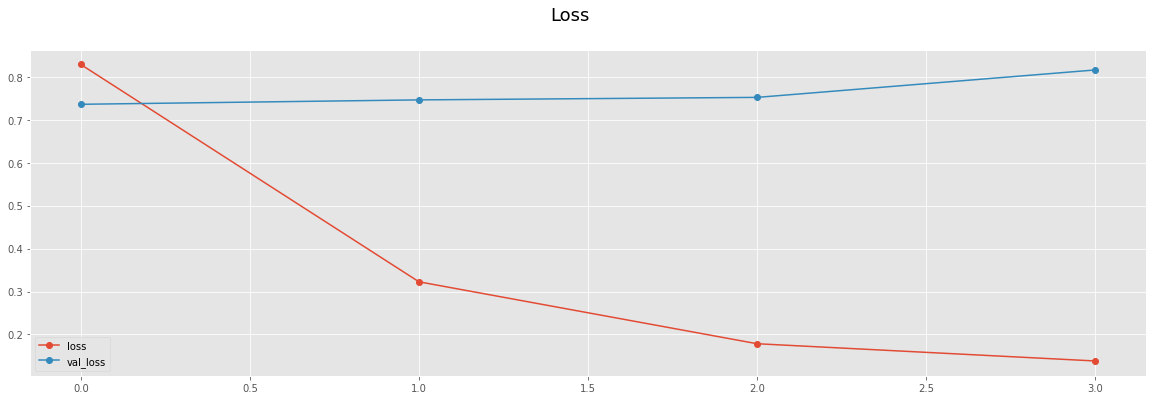

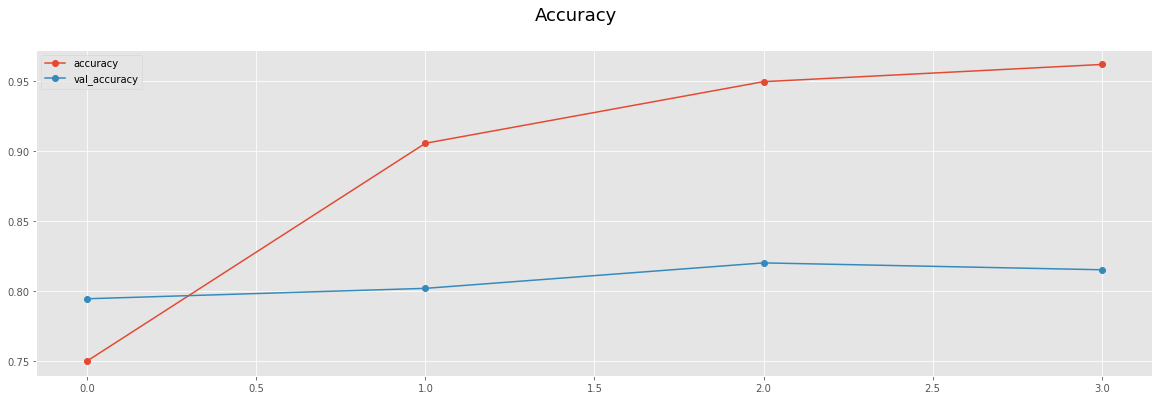

Epoch 00004: early stopping


In [5]:
tf.keras.backend.clear_session()

config = DistilBertConfig()
config.output_hidden_states = False
backbone = TFDistilBertModel.from_pretrained(checkpoint, config=config)

input_ids_in = tf.keras.layers.Input(shape=(input_shape,), name='input_token', dtype='int32')
input_masks_in = tf.keras.layers.Input(shape=(input_shape,), name='masked_token', dtype='int32') 
features = backbone(input_ids_in, attention_mask=input_masks_in)[0]
features = layers.GlobalAvgPool1D()(features)
outputs = layers.Dense(n_classes, activation='softmax', name='classification_head')(features)

model = models.Model([input_ids_in, input_masks_in], outputs)
model.summary()

model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics='accuracy')
model.fit(
    x_train, y_train, validation_data=(x_valid, y_valid), 
    batch_size=8, epochs=10, callbacks=get_callbacks('model')
 )

## Bagging

In [6]:
class BaggingHead(models.Model):
    def __init__(self, n_units, activation, size, rate, **kwargs):
        super().__init__(**kwargs)
        self.dense = layers.Dense(n_units)
        self.dropouts = [layers.Dropout(rate) for _ in range(size)]
        self.average = layers.Average()
        self.activation = layers.Activation(activation)
        
        
    def call(self, inputs):
        outputs = [self.dense(dropout(inputs)) for dropout in self.dropouts]
        averaged = self.average(outputs)
        activated = self.activation(averaged)
        return activated
        

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'vocab_transform', 'activation_13', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_token (InputLayer)        [(None, 512)]        0                                            
__________________________________________________________________________________________________
masked_token (InputLayer)       [(None, 512)]        0                                            
__________________________________________________________________________________________________
tf_distil_bert_model (TFDistilB TFBaseModelOutput(la 66362880    input_token[0][0]                
                                                                 masked_token[0][0]               
__________________________________________________________________________________________________
global_average_pooling1d (Globa (None, 768)          0           tf_distil_bert_model[0][0]   

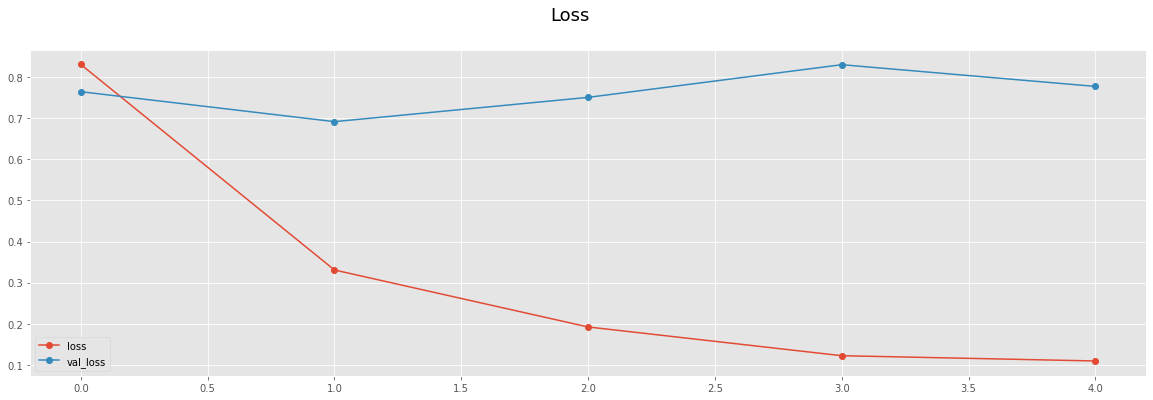

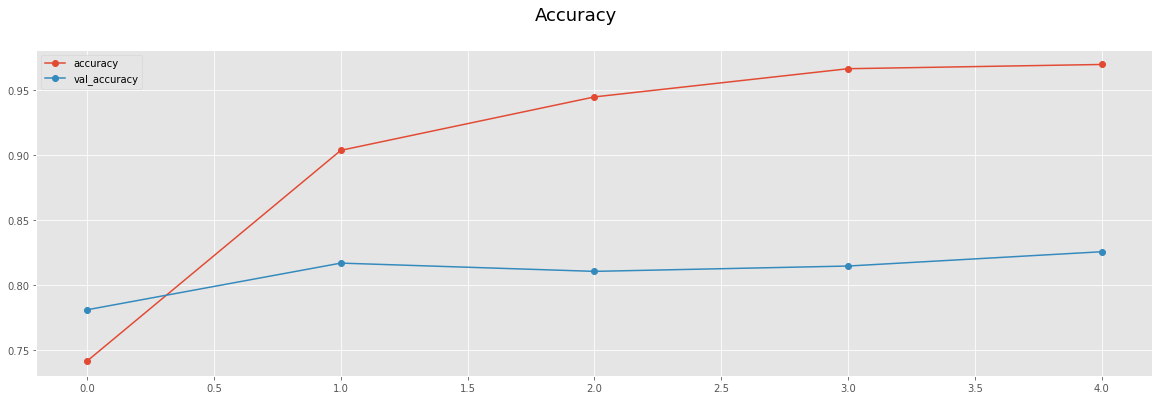

Epoch 00005: early stopping


In [7]:
tf.keras.backend.clear_session()

config = DistilBertConfig()
config.output_hidden_states = False
backbone = TFDistilBertModel.from_pretrained(checkpoint, config=config)

input_ids_in = tf.keras.layers.Input(shape=(input_shape,), name='input_token', dtype='int32')
input_masks_in = tf.keras.layers.Input(shape=(input_shape,), name='masked_token', dtype='int32') 
features = backbone(input_ids_in, attention_mask=input_masks_in)[0]
features = layers.GlobalAvgPool1D()(features)
outputs = BaggingHead(n_classes, activation='softmax', size=5, rate=0.2, name='bagging_classification_head')(features)

model = models.Model([input_ids_in, input_masks_in], outputs)
model.summary()

model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics='accuracy')
model.fit(
    x_train, y_train, validation_data=(x_valid, y_valid), 
    batch_size=8, epochs=10, callbacks=get_callbacks('model')
 )